# TO-DO
+ Why were we dropping quarters with <3months of data in past iteration?

In [3]:
# !pip install gdown

In [2]:
import pandas as pd
import numpy as np
import gdown
import random
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
# define paths and seed
seed = 92
data_path = "./"

In [4]:
# define dictionary with paths to data in Google Drive
data_url_dict = {"mpc_minutes": ("https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR", "txt"),
                "ons_quarterly_gdp": ("https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD", "csv")}

In [5]:
# download each file in the dictionary
for file_name, attributes in data_url_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1k086m12gBHKuVMPv4GUD1aB_kZOZpznR
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/mpc_minutes.txt
100%|██████████| 7.36M/7.36M [00:00<00:00, 23.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_8JwCNUsq9wnPiTDmcJ2xrWklGGDFbQD
To: /Users/llaurabat/Dropbox/BGSE_work/AR/ARE_text_algorithms_economics/notebooks/ons_quarterly_gdp.csv
100%|██████████| 3.33k/3.33k [00:00<00:00, 12.0MB/s]


## 0. Load data

This tutorial uses text data from Bank of England minutes. As a first step, we inspect the data. We observe that we have a total number of 7277 strings of data (hereafter "documents") that are produced monthly for 18 years (06/1997 to 10/2014). The average length of a document is of 161 words.

In [6]:
data = pd.read_csv(data_path + 'mpc_minutes.txt', delimiter='\t', header=0, names=['date', 'minutes'])
print(data.shape)
data.head()

(7277, 2)


,date,minutes
0,199706,1 Sections I to V of this minute summarise t...
1,199706,The 12-month growth rate of notes and coins ...
2,199706,"Broad money, too, decelerated in April: its ..."
3,199706,Lending growth continued at around 9% in ...
4,199706,Lending to individuals remained robust in...


In [7]:
# turn date into date format and create quarter column
data['date'] = pd.to_datetime(data.date, format='%Y%m')
data['year'] = data.date.dt.year.astype(int)
data['quarter'] = data.date.dt.quarter.astype(int)
data['date'] = data['date'].dt.strftime('%Y%m')
data.head()

,date,minutes,year,quarter
0,199706,1 Sections I to V of this minute summarise t...,1997,2
1,199706,The 12-month growth rate of notes and coins ...,1997,2
2,199706,"Broad money, too, decelerated in April: its ...",1997,2
3,199706,Lending growth continued at around 9% in ...,1997,2
4,199706,Lending to individuals remained robust in...,1997,2


In [8]:
data['length'] = data.minutes.apply(lambda x: len(x.split()))
print(f'average document length: {np.round(np.mean(data.length),0)} words')

average document length: 161.0 words


In [9]:
print('n. months:',len(data.date.unique()))
print('n. years:',len(data.year.unique()))
data.date.unique()

n. months: 209
n. years: 18


array(['199706', '199707', '199708', '199709', '199710', '199711',
       '199712', '199801', '199802', '199803', '199804', '199805',
       '199806', '199807', '199808', '199809', '199810', '199811',
       '199812', '199901', '199902', '199903', '199904', '199905',
       '199906', '199907', '199908', '199909', '199910', '199911',
       '199912', '200001', '200002', '200003', '200004', '200005',
       '200006', '200007', '200008', '200009', '200010', '200011',
       '200012', '200101', '200102', '200103', '200104', '200105',
       '200106', '200107', '200108', '200109', '200110', '200111',
       '200112', '200201', '200202', '200203', '200204', '200205',
       '200206', '200207', '200208', '200209', '200210', '200211',
       '200212', '200301', '200302', '200303', '200304', '200305',
       '200306', '200307', '200308', '200309', '200310', '200311',
       '200312', '200401', '200402', '200403', '200404', '200405',
       '200406', '200407', '200408', '200409', '200410', '2004

## 8. Example of dictionary methods

Consider a situation where we want to investigate the sentiment of each meeting minute. 
A simple and sensible way to do so would be to build a document sentiment index based on the count of words having a "positive" or "negative" sentiment. We will then evaluate such an index for each of the minutes, and compare the measured sentiment to UK GDP as measured by the Office for National Statistics.

Firstly, we need to define the terms having positive or negative sentiment.
For this example, we use the monetary policy sentiment dictionaries from Apel and Blix-Grimaldi (2012).

In [10]:
pos_words = ['accelerate','accelerated','accelerates','accelerating','expand','expanded','expanding','expands',
             'fast','faster','fastest','gain','gained','gaining','gains','high','higher','highest','increase',
             'increased','increases','increasing','strong','stronger','strongest']

In [11]:
neg_words = ['contract','contracted','contracting','contracts','decelerate','decelerated','decelerates',
             'decelerating','decrease','decreased','decreases','decreasing','lose','losing','loss','losses',
             'lost','low','lower','lowest','slow','slower','slowest','weak','weaker','weakest']

The overall sentiment indicator will be formed of the net count of positive words divided by the total number of sentiment words (positive + negative). 

We can immediately notice that the dictionaries are lowercased, while the minutes data is not. When searching the minutes for sentiment terms, we do not want casing to interefere. Therefore, it is a good idea to lower-case the minutes data first. To do so, we can call the method ```lower()``` on each string. 

In [12]:
data['minutes_lower'] = data.minutes.apply(lambda x: x.lower())

By using regular expressions, we can now count the number of times a positive or negative words was used in each of the minutes.

In [13]:
def count_instances(text, target_list):
    target_string = '|'.join(target_list)
    matches = re.findall(fr"\b({target_string})\b", text)
    return len(matches)

In [14]:
data['pos_counts'] = data.minutes_lower.apply(lambda x: count_instances(text=x, target_list=pos_words))
data['neg_counts'] = data.minutes_lower.apply(lambda x: count_instances(text=x, target_list=neg_words))

We can now compute sentiment at the year-quarter level, and compare it to UK GDP.

In [15]:
data_agg = data.groupby(['year', 'quarter']).sum()[['pos_counts', 'neg_counts']]#, 'months_x_quarter']]

In [16]:
# compute sentiment at year-quarter level
data_agg['sentiment'] = (data_agg.pos_counts - data_agg.neg_counts)/(data_agg.pos_counts + data_agg.neg_counts)
data_agg.head()

pos_counts  neg_counts  sentiment
year quarter                                   
1997 2                30          16   0.304348
     3               240          85   0.476923
     4               239          90   0.452888
1998 1               265         123   0.365979
     2               265         145   0.292683

In [17]:
ons = pd.read_csv(data_path + 'ons_quarterly_gdp.csv', names=['label', 'gdp_growth', 'quarter_long'], header=0)

ons['year'] = ons.label.apply(lambda x: x[:4]).astype(int)
ons['quarter'] = ons.label.apply(lambda x: x[6]).astype(int)

ons = ons[['year', 'quarter', 'gdp_growth']]

ons = ons.drop_duplicates().reset_index(drop=True).copy()
ons.head()

,year,quarter,gdp_growth
0,1997,2,1.2
1,1997,3,0.6
2,1997,4,1.3
3,1998,1,0.6
4,1998,2,0.6


In [20]:
# merge to sentiment data
df = data_agg.merge(ons, how='left', on=['year', 'quarter']).reset_index(drop=True).copy()
df.head()

,year,quarter,pos_counts,neg_counts,sentiment,gdp_growth
0,1997,2,30,16,0.304348,1.2
1,1997,3,240,85,0.476923,0.6
2,1997,4,239,90,0.452888,1.3
3,1998,1,265,123,0.365979,0.6
4,1998,2,265,145,0.292683,0.6


In [21]:
ticks = np.arange(0, df.shape[0], 5)
labs = np.array([str(x)+'Q'+str(y) for x,y in zip(df['year'],df['quarter'])])
labs = labs[ticks]

# save for later use
df = df[['year', 'quarter', 'sentiment', 'gdp_growth']].copy()
df.to_csv(data_path + 'gdp_sentiment.csv')


In [22]:
print(df[['sentiment', 'gdp_growth']].corr())

            sentiment  gdp_growth
sentiment    1.000000    0.286951
gdp_growth   0.286951    1.000000


In spite of its arguable lack of subtlety, here dictionary methods have produced a sentiment indicator that indeed correlates with real activity. Full results are in output.csv. Below we plot standardized series for growth and sentiment.

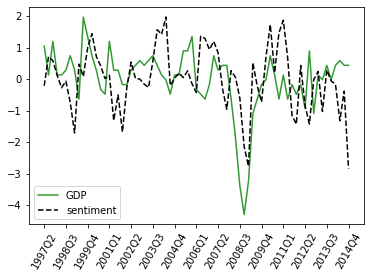

In [23]:
scaler = StandardScaler()

fig, ax = plt.subplots()
ax.plot(scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)).flatten(), 
        label='GDP', c='green', alpha=0.8)
ax.plot(scaler.fit_transform(df.sentiment.values.reshape(-1, 1)).flatten(), 
        label='sentiment', linestyle='dashed', c='black')

ax.set_xticks(ticks)
ax.set_xticklabels(labs, rotation=60)
ax.legend()

plt.show()
